In [ ]:
# pip install tensorflow
# pip install tensorflow_datasets
# pip install keras_cv
# pip install luketils
# pip install matplotlib

##### 만든이 : lukewood
##### 최초 작성일 : 2022/08/22
##### 마지막 수정일 : 2022/08/22
##### 설명 : Pascal VOC 2007 이미지 데이터셋을 RetinaNet으로 학습하기 위해 KerasCV을 사용합니다.

### 개요

KerasCV는 최신 및 상용 수준의 객체 감지 (object detection) 모델을 학습하기 위한 완벽한 API를 제공합니다. 객체 감지에 특화한 데이터 어그먼트 (data augmentation), 모델, COCO 지표 (metric)을 제공합니다.

객체 감지를 위해 필요한 라이브러리를 불러오고, 파라미터 설정을 하겠습니다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
from keras_cv import bounding_box
import os
from luketils import visualization

In [2]:
BATCH_SIZE = 16
EPOCHS = int(os.getenv("EPOCHS", "1"))
CHECKPOINT_PATH = os.getenv("CHECKPOINT_PATH", "checkpoint/")
INFERENCE_CHECKPOINT_PATH = os.getenv("INFERENCE_CHECKPOINT_PATH", CHECKPOINT_PATH)

### 데이터 불러오기 (Data loading)
윈도우즈의 경우 아래와 같은 경로에 이미지 데이터셋을 다운로드합니다.

c:\Users\[사용자이름]\tensorflow_datasets\voc\2007\4.0.0\ 

이 노트북에서는 이미지 데이터를 불러오기 위해 keras_cv.datasets.pascal_voc.load()라는 함수를 사용합니다. KerasCV는 객체 위치를 표시를 처리하는 모든 요소 (component)에 bounding_box_format를 전달해야 합니다. KerasCV API 형식에 맞도록 자신만의 데이터를 불러올 때 bounding_box_format를 꼭 추가해주어야 합니다. 이는 객체 위치를 표시할 때 어떤 형식으로 지정할지를 명확하게 해줍니다.

아래를 참고하세요:

In [3]:
train_ds, ds_info = keras_cv.datasets.pascal_voc.load(
    split='train', bounding_box_format='xywh', batch_size=8
)

xywh 형식으로 객체를 표시하겠다고 명확히 했습니다. [API 문서](https://keras.io/api/keras_cv/bounding_box/formats/)에서 KerasCV의 bounding_box_format에 대해서 더 자세히 알 수 있습니다.

데이터는 {"images": images, "bounding_boxes": bounding_boxes}와 같은 형식으로 되어 있습니다. 이 형식은 모든 kerasCV 전처리 컴포넌트에서 사용합니다. 

데이터를 한번 확인해 보겠습니다.

In [5]:
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train", bounding_box_format="xywh", batch_size=BATCH_SIZE
)

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )

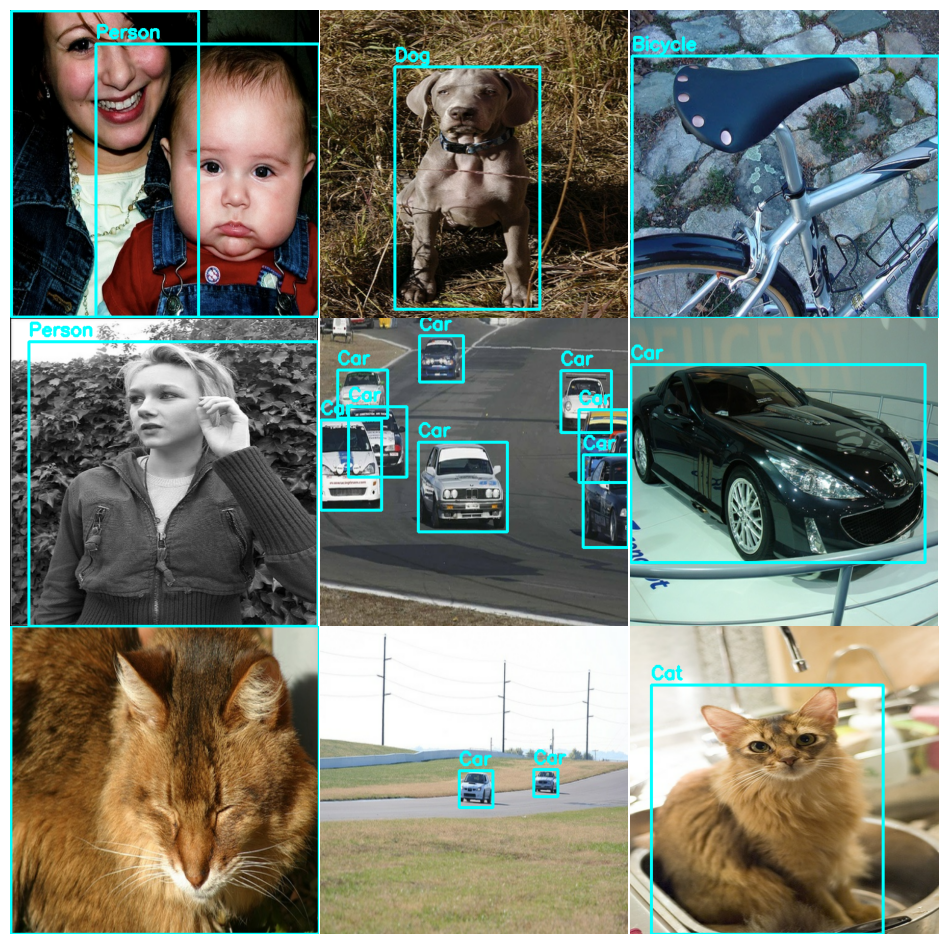

In [7]:
visualize_dataset(dataset, bounding_box_format="xywh")

예상대로 이미지를 잘 불러오고, 객체를 잘 표시하고 있습니다. 이제 데이터 어그먼트 파이프라인을 만들어 보겠습니다.

### 데이터 어그먼트 (Data augmentation)
객채 감지 파이프라인을 만들 때 아주 귀찮으면서도 힘든 과정 중에 하나가 데이터 어그먼트입니다. 이미지 어그먼트 방법은 기본적으로는 객체 감지를 인식하고, 상황에 따라 다시 객체 인식을 해야 합니다.

다행히도, KerasCV는 기본적으로 data augmentation 계층이라는 라이브러리를 통해 객체 감지 표시 어그먼트를 지원합니다. 아래 소스코드는 Pascal VOC 데이터셋을 불러와서 tr.data 파이프라인 과정에 바로 데이터 어그먼트를 객체 감지 표시를 수행합니다.

In [14]:
train_ds, train_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="train", batch_size=BATCH_SIZE
)
val_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
    bounding_box_format="xywh", split="validation", batch_size=BATCH_SIZE
)

In [15]:
random_flip = keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh")
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    # we disable geometric augmentations for object detection tasks
    geometric=False,
)

In [16]:
def augment(inputs):
    # In future KerasCV releases, RandAugment will support
    # bounding box detection
    inputs["images"] = rand_augment(inputs["images"])
    inputs = random_flip(inputs)
    return inputs

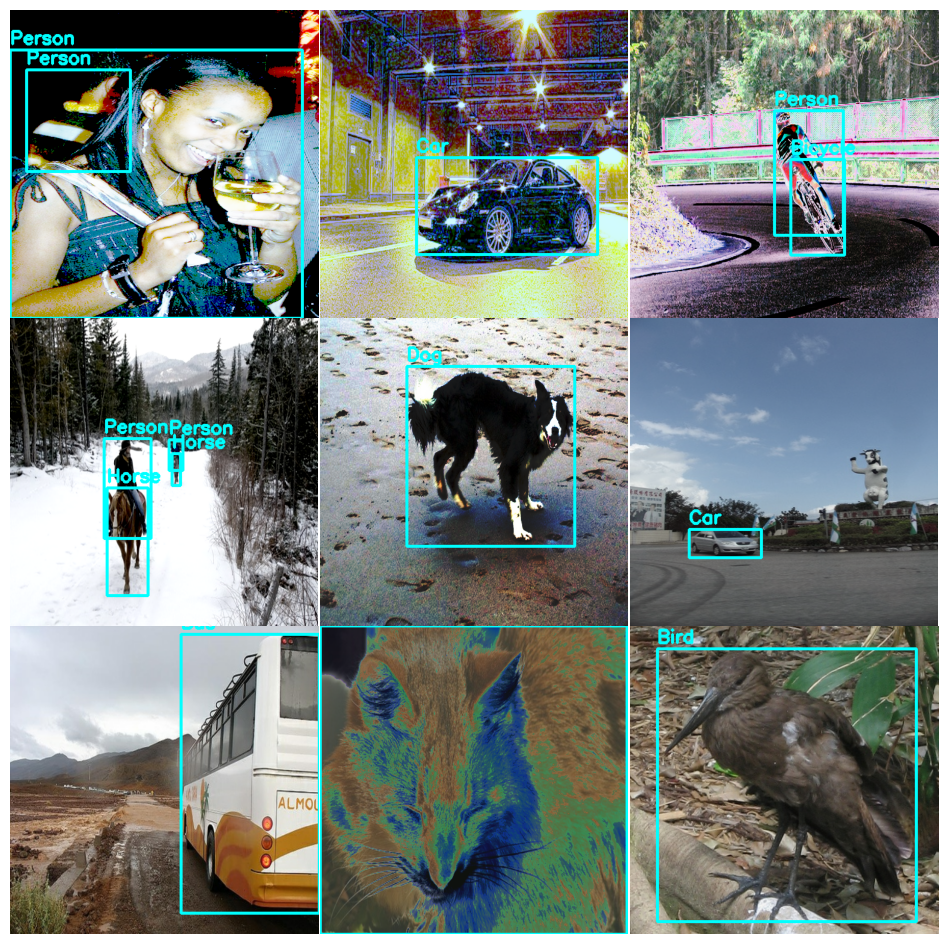

In [17]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(train_ds, bounding_box_format="xywh")

멋지게도 쉽게 데이터 어그먼트 파이프라인 과정에서 객체 감지 표시를 해주었습니다.

이제 데이터를 준비해보겠습니다. 이전에 처리한 딕셔너리에서 입력할 부분을 처리하고, 모델에 입력 할 수 있도록 준비하겠습니다.

In [18]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [19]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

이제 파이프라인 과정을 완료 되었습니다. 모델을 생성하고 학습할 준비가 되었습니다.

### 모델 생성 (Model creation)

RetinaNet 모델을 생성하기 위해 KerasCV API을 사용합니다. 이 노트북에서는 사전에 학습한 ResNet50 모델을 사용합니다. 이 모델은 imagenet 데이터셋으로 학습한 가중치를 적용사용합니다. 학습을 하기 전에 모델을 freeze시켜 fine-tuning을 수행합니다. include_rescaling=True를 설정하면 모델의 입력은 [0, 255] 안의 값을 가진다고 가정합니다.

In [20]:
model = keras_cv.models.RetinaNet(
    # 감지할 클래스 의 갯수
    classes=20,
    # 지원하는 bounding box formats에 대해서 더 자세히 표기 위해 아래 링크를 참조합니다.
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    # KerasCV는 사전 학습한 모델을 제공합니다
    backbone="resnet50",
    # 각 모델은 학습한 가중치를 가지고 있습니다
    # 이 가중치는 `keras_cv.model` 클래스의 가중치와 일치합니다.
    backbone_weights="imagenet",
    # include_rescaling는 모델에게 이미지의 픽셀값이 (0, 255)라는 것을 알려주거나
    # 이미 0과 255 사이의 값으로 조정했다면 그 값은 (0, 1) 사이라고 알려줍니다.
    # 예제의 경우, (0, 255)로 입력값을 사용합니다.
    include_rescaling=True,
    # 일반적으로 실제 모델을 학습할 때는 이 값은 False로 설정하려고 합니다.
    # evaluate_train_time_metrics=True 는 `train_step()`가 TPU와 호환되지 않습니다,
    # 또한, 많은 처리량이 필요합니다. 모델 학습 파이프라인을 디버깅할 때, 유용합니다
    evaluate_train_time_metrics=False,
)
# RetinaNet을 파인 튜닝하는 것은 backbone.trainable = False로 간단히 할 수 있습니다.
model.backbone.trainable = False

KerasCV RetinaNet이 준비되었습니다. RetinaNet은 튜플 형식으로 이미지 텐서를 허용합니다. 객체 감지 텐서를 fit()과 train_on_batch()로 준비시킵니다. 앞에 준비한 파이프라인 입력에 만든 입력과 일치시킵니다.

### COCO 지표로 평가하기

KerasCV는 일괄 평가를 지원하는 그래프 내 COCO 지표를 제공합니다. 이러한 측정항목에 대한 자세한 내용은 다음에서 확인할 수 있습니다:


* [Efficient Graph-Friendly COCO Metric Computation for Train-Time Model Evaluation](https://arxiv.org/abs/2207.12120)
* [Using KerasCV COCO Metrics](https://keras.io/guides/keras_cv/coco_metrics/)

두 개의 COCO 메트릭, 즉 표준 COCO 평균 평균 정밀도 메트릭과 일치하도록 매개변수화한 [keras_cv.metrics.COCOMeanAveragePrecision](https://keras.io/api/keras_cv/metrics/coco_mean_average_precision#cocomeanaverageprecision-class) 인스턴스와 표준 COCO Recall 지표와 일치하도록 매개변수화된 [keras_cv.metrics.COCORecall](https://keras.io/api/keras_cv/metrics/coco_recall#cocorecall-class) 인스턴스를 구성해 보겠습니다.

주목해야 할 중요한 점은 기본적으로 KerasCV RetinaNet이 학습 시간에 메트릭을 평가하지 않는다는 것입니다. 이는 최적의 GPU 성능과 TPU 호환성을 보장하기 위한 것입니다. 학습 시간 지표를 평가하려면 [keras_cv.models.RetinaNet](https://keras.io/api/keras_cv/models/retinanet#retinanet-class) 생성자에 evaluate_train_time_metrics=True를 전달할 수 있습니다. 이 때문에 훈련 중에는 테스트 세트를 작게 유지하고 훈련 후 단계로 전체 평가 세트에 대한 COCO 지표만 평가하는 것이 좋습니다.

In [21]:
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(20),
        bounding_box_format="xywh",
        name="Mean Average Precision",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

### 모델 학습시키기

이제 남은 부분은 모델을 학습시키기 입니다. KerasCV 객체 탐지 모델은 compile() and fit()를 사용하는 표준 Keras 방식을 따릅니다.

모델을 compile해보겠습니다:

In [22]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=[
        keras_cv.metrics.COCOMeanAveragePrecision(
            class_ids=range(20),
            bounding_box_format="xywh",
            name="Mean Average Precision",
        ),
        keras_cv.metrics.COCORecall(
            class_ids=range(20),
            bounding_box_format="xywh",
            max_detections=100,
            name="Recall",
        ),
    ],
)

이제 몇 가지 콜백 함수를 준비합니다:

In [23]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="logs"),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    # Uncomment to train your own RetinaNet
    keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True),
]

자, 이제 학습하기 위해 model.fit()를 실행합니다!

In [24]:
model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=EPOCHS,
    callbacks=callbacks,
)
model.save_weights(CHECKPOINT_PATH)

157/157 [==============================] - 4255s 27s/step - loss: 26.4052 - classification_loss: 13.4794 - regularization_loss: 0.0000e+00 - box_loss: 12.9257 - val_Mean Average Precision: 0.0015 - val_Recall: 0.0030 - val_loss: 23.1495 - val_classification_loss: 11.4885 - val_box_loss: 11.6610 - val_regularization_loss: 0.0000e+00 - lr: 0.0100


이제 model.evaluate()를 사용해서 모델을 평가합니다:

In [25]:
model.load_weights(INFERENCE_CHECKPOINT_PATH)
metrics = model.evaluate(val_ds.take(100), return_dict=True)
print(metrics)

100/100 [==============================] - 1445s 14s/step - Mean Average Precision: 9.3346e-04 - Recall: 0.0023 - loss: 22.8771 - classification_loss: 11.3847 - box_loss: 11.4924 - regularization_loss: 0.0000e+00
{'Mean Average Precision': 0.0009334593778476119, 'Recall': 0.002250318182632327, 'loss': 22.87713050842285, 'classification_loss': 11.3847017288208, 'box_loss': 11.492430686950684, 'regularization_loss': 0.0}


### 추론
KerasCV는 객체 감지 추론을 간단하게 만듭니다. model.predict(images)는 경계 상자의 RaggedTensor를 반환합니다. 기본적으로 RetinaNet.predict()는 최대가 아닌 억제 작업을 수행합니다.

1/1 [==============================] - 11s 11s/step


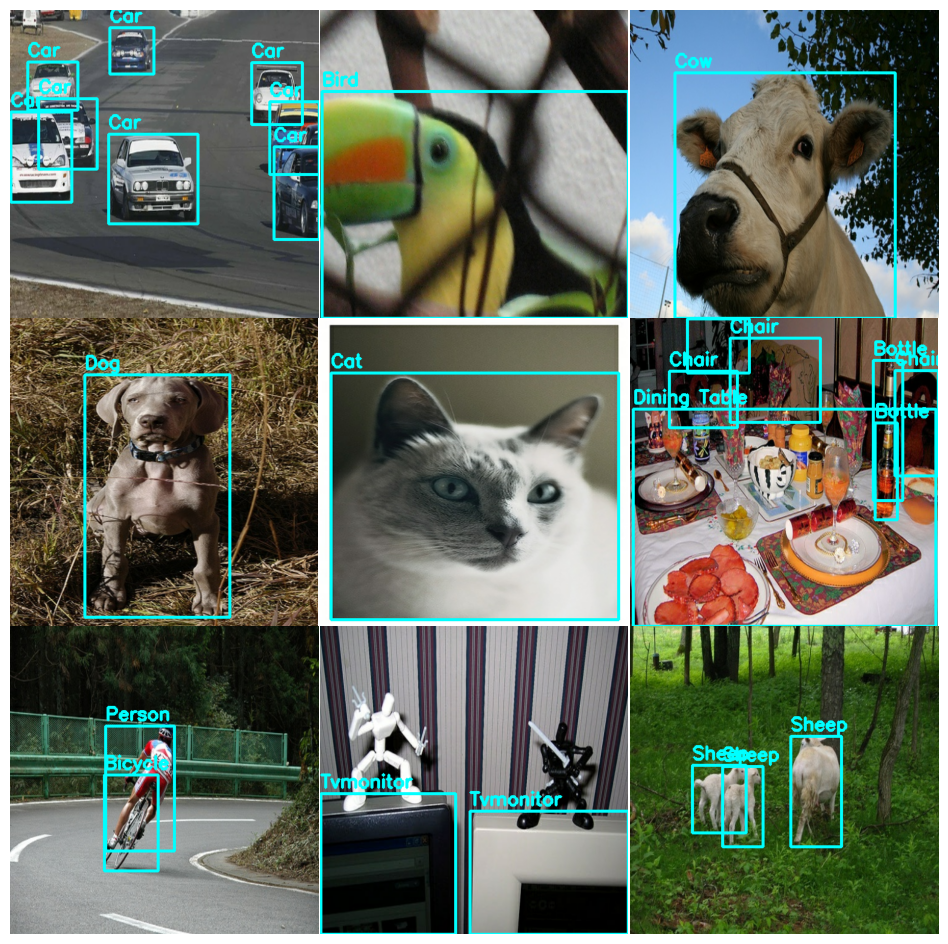

In [26]:
def visualize_detections(model, bounding_box_format):
    train_ds, val_dataset_info = keras_cv.datasets.pascal_voc.load(
        bounding_box_format=bounding_box_format, split="train", batch_size=BATCH_SIZE
    )
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )


visualize_detections(model, bounding_box_format="xywh")

좋은 결과를 얻으려면 적어도 100 Epoch 동안 훈련해야 합니다. 또한 prediction decoder 계층을 조정해야 합니다. 다음과 같이 사용자 정의 prediction decoder를 RetinaNet 생성자에 전달하여 수행할 수 있습니다:

1/1 [==============================] - 17s 17s/step


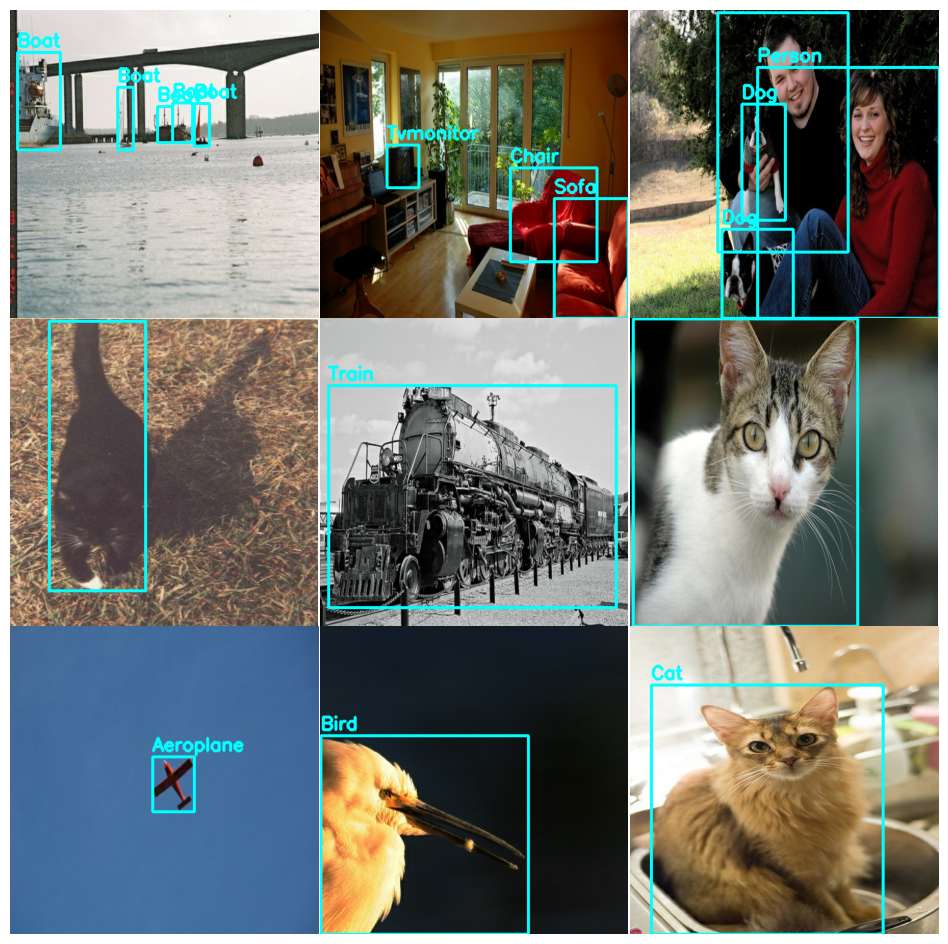

In [27]:
prediction_decoder = keras_cv.layers.NmsPredictionDecoder(
    bounding_box_format="xywh",
    anchor_generator=keras_cv.models.RetinaNet.default_anchor_generator(
        bounding_box_format="xywh"
    ),
    suppression_layer=keras_cv.layers.NonMaxSuppression(
        iou_threshold=0.75,
        bounding_box_format="xywh",
        classes=20,
        confidence_threshold=0.85,
    ),
)
model.prediction_decoder = prediction_decoder
visualize_detections(model, bounding_box_format="xywh")

### 결과 및 결론

KerasCV를 사용하면 최첨단 객체 감지 파이프라인을 쉽게 구성할 수 있습니다. 모든 KerasCV 객체 감지 구성 요소는 독립적으로 사용할 수 있지만 서로 긴밀하게 통합되어 있습니다. KerasCV를 사용하면 객체 감지 위치 어그먼테이션, 학습 시간 COCO  지표 평가 등을 모두 간단하고 일관되게 수행할 수 있습니다.

남은 과제 :

* 모델 성능을 향상시키기 위해 추가적인 어그멘테이션을 추가합니다.
* 최적의 평균 평균 정밀도를 달성하기 위한 NmsPredictionDecoder의 그리드 검색 confidence_threshold 및 iou_threshold
* 고품질 결과를 생성하는데 사용되는 하이퍼파라미터 및 데이터 어그먼테이션 조정
* 다른 데이터 세트에서 객체 감지 모델 학습